### Part 1
Some data wrangling

Some outlier removal based on domain knowledge

Use Column Transformer and Pipeline to streamline process

Use Randomized Search to find optimal set of parameters

Automate the procedure for multiple classifiers

Plot Precision-Recall Curve

Plot Learning Curve (for bias-variance tradeoff / check for overfitting-underfitting) 


### Part 2
Rectify existing model based on inferences from the learning curve and make a better one

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import plot_precision_recall_curve
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from lightgbm import LGBMClassifier

In [4]:
df = pd.read_csv('credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
dups = df.duplicated()

In [6]:
df[dups]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15989,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.36,0,0.09,N,3
15995,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.42,0,0.08,N,4
16025,24,10000,RENT,8.0,PERSONAL,A,3000,7.90,1,0.30,N,3
16028,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,0,0.15,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32010,42,39996,MORTGAGE,2.0,HOMEIMPROVEMENT,A,2500,5.42,0,0.06,N,12
32047,36,250000,RENT,2.0,DEBTCONSOLIDATION,A,20000,7.88,0,0.08,N,17
32172,49,120000,MORTGAGE,12.0,MEDICAL,B,12000,10.99,0,0.10,N,12
32259,39,40000,OWN,4.0,VENTURE,B,1000,10.37,0,0.03,N,16


In [7]:
# query of 1st record match from above dataset

df.query("person_age==23 & person_income==42000 &\
person_home_ownership=='RENT' & loan_int_rate==9.99")

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
6464,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4


In [8]:
df.shape

(32581, 12)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(32416, 12)

In [11]:
# X, y=train _test=test
# random_state=normal dist
# stratify=normalize (train/test =)
# X and y will be thought of as the entire training data
# X_test and y_test will be thought of as the out of sample data for model evaluation

X, X_test, y, y_test = train_test_split(df.drop('loan_status', axis=1), df['loan_status'],
                                        random_state=0,  test_size=0.2, stratify=df['loan_status'],
                                        shuffle=True)

In [12]:
df['loan_status'].value_counts(normalize=True)

0    0.781312
1    0.218688
Name: loan_status, dtype: float64

In [13]:
y.value_counts(normalize=True)

0    0.781313
1    0.218687
Name: loan_status, dtype: float64

In [14]:
y_test.value_counts(normalize=True)

0    0.781308
1    0.218692
Name: loan_status, dtype: float64

In [15]:
np.round(X.isna().sum()* 100 / X.shape[0], 3)

person_age                    0.000
person_income                 0.000
person_home_ownership         0.000
person_emp_length             2.800
loan_intent                   0.000
loan_grade                    0.000
loan_amnt                     0.000
loan_int_rate                 9.614
loan_percent_income           0.000
cb_person_default_on_file     0.000
cb_person_cred_hist_length    0.000
dtype: float64

In [16]:
X.shape

(25932, 11)

In [17]:
X.dropna().shape

(22763, 11)

In [18]:
#we see 12% data gets delected by missing values so KEEP
(25932-22763)/25932

0.12220422643837729

In [19]:
#loan_percent_income=loan_amt/person_income (so delete)

X[['person_income', 'loan_amnt', 'loan_percent_income']].head()

,person_income,loan_amnt,loan_percent_income
21415,48000,10000,0.21
12916,85000,7500,0.09
2938,125000,3000,0.02
19114,62000,2300,0.04
6057,48000,4200,0.09


In [20]:
#drop the last col

X.drop('loan_percent_income', axis=1, inplace=True)
X_test.drop('loan_percent_income', axis=1, inplace=True)

In [21]:
#unique vals 
# unique vals < 20

for col in X:
    print(col, '--->', X[col].nunique())
    if X[col].nunique()<20:
        print(X[col].value_counts(normalize=True)*100)
    print()

person_age ---> 58

person_income ---> 3680

person_home_ownership ---> 4
RENT        50.320068
MORTGAGE    41.439149
OWN          7.916859
OTHER        0.323924
Name: person_home_ownership, dtype: float64

person_emp_length ---> 36

loan_intent ---> 6
EDUCATION            19.809502
MEDICAL              18.787598
VENTURE              17.542033
PERSONAL             16.878760
DEBTCONSOLIDATION    15.968687
HOMEIMPROVEMENT      11.013420
Name: loan_intent, dtype: float64

loan_grade ---> 7
A    32.932284
B    32.126330
C    19.902052
D    11.121394
E     3.004010
F     0.732685
G     0.181243
Name: loan_grade, dtype: float64

loan_amnt ---> 710

loan_int_rate ---> 346

cb_person_default_on_file ---> 2
N    82.392411
Y    17.607589
Name: cb_person_default_on_file, dtype: float64

cb_person_cred_hist_length ---> 29



In [22]:
X.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,cb_person_cred_hist_length
count,25932.000000,2.593200e+04,25206.000000,25932.000000,23439.000000,25932.000000
mean,27.721155,6.589884e+04,4.811315,9611.395187,11.013784,5.793460
std,6.382311,6.333831e+04,4.172822,6339.054572,3.240104,4.052297
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,2.000000
25%,23.000000,3.849500e+04,2.000000,5000.000000,7.900000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,4.000000
75%,30.000000,7.900000e+04,7.000000,12250.000000,13.480000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,30.000000


# max of person age and emp_len are diff so scale it


In [23]:
# non object cols ( !=O) =num cols

num_cols = [col for col in X if X[col].dtypes != 'O']
num_cols

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'cb_person_cred_hist_length']

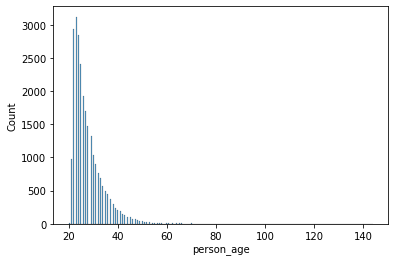

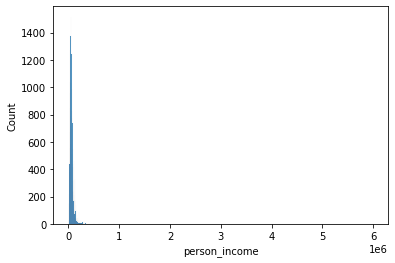

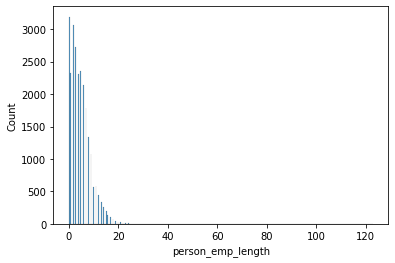

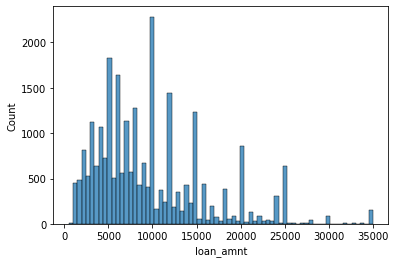

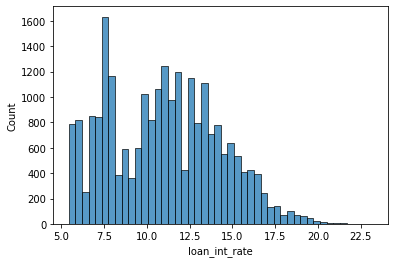

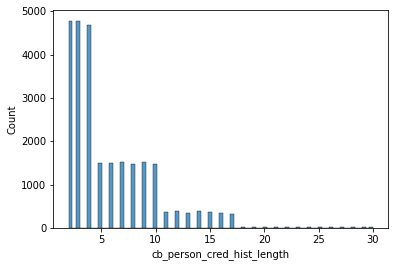

In [24]:
import seaborn as sns

for col in num_cols:
    sns.histplot(X[col])
    plt.show()

In [25]:
# person >=80 wont ask for loan

X.loc[X['person_age']>=80, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,cb_person_default_on_file,cb_person_cred_hist_length
32422,80,64000,RENT,7.0,MEDICAL,B,6800,11.71,N,25
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,N,3
32416,94,24000,RENT,1.0,MEDICAL,C,6500,NaN,N,27
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,N,4
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,N,3
32506,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,N,24
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,N,25


In [26]:
#new dataset -80s

X = X.loc[X['person_age']<80, :]

In [27]:
X.shape

(25924, 10)

In [28]:
#bcz only 14yo can apply for loan so 80-14=66

X.loc[X['person_emp_length']>=66, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,cb_person_default_on_file,cb_person_cred_hist_length
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,N,4
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,Y,3


In [29]:
#same

df.query("person_age<=person_emp_length+14")

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


In [30]:
#no null rmv

X = X.loc[(X['person_emp_length']<66) | (X['person_emp_length'].isna()), :]

In [31]:
# since we've removed some data from X, we need to pass on these updations to y as well,
# as y doesn't know some of its corresponding X's have been deleted.
y = y[X.index]

In [32]:
#categorial cols

cat_cols = [col for col in X if X[col].dtypes == 'O']
cat_cols

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [33]:
#compute missing val=imputer
# scale 

num_pipe = Pipeline([
    ('impute', IterativeImputer()),
    ('scale', StandardScaler()),
])

In [34]:
# for missing values =col transformer (num cols)
# cat cols=one hot rep (1-0)

ct = ColumnTransformer([
    ('num_pipe', num_pipe, num_cols),
    ('cat_cols', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

In [35]:
# random forest=LGBMClassifier=model
# n_jobs=-1 (all CPUs)
# estimators = sub trees
# coltf__num_pipe__impute__estimator= as name =model

In [36]:
grid = {
    RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced'):
    {'model__n_estimators':[300,400,500],
     'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]},
    
    LGBMClassifier(class_weight='balanced', random_state=0, n_jobs=-1):
    {'model__n_estimators':[300,400,500],
     'model__learning_rate':[0.001,0.01,0.1,1,10],
     'model__boosting_type': ['gbdt', 'goss', 'dart'],
     'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]},
}

In [37]:
# j to print above

for clf, param in grid.items():
    print(clf)
    print('-'*50)
    print(param)
    print('\n')

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)
--------------------------------------------------
{'model__n_estimators': [300, 400, 500], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}


LGBMClassifier(class_weight='balanced', random_state=0)
--------------------------------------------------
{'model__n_estimators': [300, 400, 500], 'model__learning_rate': [0.001, 0.01, 0.1, 1, 10], 'model__boosting_type': ['gbdt', 'goss', 'dart'], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}




In [ ]:
#dataframe
#dictionary {}
# classifer=clf and param of above grid.items
# randomsearchcv = model= random search not grid (for hypertuning)
# HYPER TUNINGGGGG ===> finding best params=high acc
#best estimator (good acc model)


In [38]:
full_df = pd.DataFrame()
best_algos = {}

for clf, param in grid.items():
    pipe = Pipeline([
    ('coltf', ct),
    ('model', clf)
])

    gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='accuracy',
                            n_jobs=-1, verbose=3, n_iter=4, random_state=0)
    
    gs.fit(X, y)
    
    all_res = pd.DataFrame(gs.cv_results_)

    temp = all_res.loc[:, ['params', 'mean_test_score']]
    algo_name = str(clf).split('(')[0]
    temp['algo'] = algo_name
    
    full_df = pd.concat([full_df, temp], ignore_index=True)
    best_algos[algo_name] = gs.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [39]:
#best algo=on top

full_df.sort_values('mean_test_score', ascending=False)

,params,mean_test_score,algo
3,"{'model__n_estimators': 400, 'coltf__num_pipe_...",0.922730,RandomForestClassifier
0,"{'model__n_estimators': 400, 'coltf__num_pipe_...",0.922537,RandomForestClassifier
2,"{'model__n_estimators': 400, 'coltf__num_pipe_...",0.922537,RandomForestClassifier
1,"{'model__n_estimators': 500, 'coltf__num_pipe_...",0.922537,RandomForestClassifier
7,"{'model__n_estimators': 300, 'model__learning_...",0.908379,LGBMClassifier
4,"{'model__n_estimators': 300, 'model__learning_...",0.869339,LGBMClassifier
5,"{'model__n_estimators': 300, 'model__learning_...",0.868606,LGBMClassifier
6,"{'model__n_estimators': 300, 'model__learning_...",0.864478,LGBMClassifier


In [40]:
# 1 row from above

full_df.sort_values('mean_test_score', ascending=False).iloc[0, 0]

{'model__n_estimators': 400,
 'coltf__num_pipe__impute__estimator': RandomForestRegressor(random_state=0)}

In [41]:
be = best_algos['RandomForestClassifier']
be

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=RandomForestRegressor(random_state=0))),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat_cols',
                                             

In [42]:
be.fit(X, y)

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=RandomForestRegressor(random_state=0))),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat_cols',
                                             

In [43]:
preds = be.predict(X_test)

In [44]:
confusion_matrix(y_test, preds)

array([[5007,   59],
       [ 436,  982]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


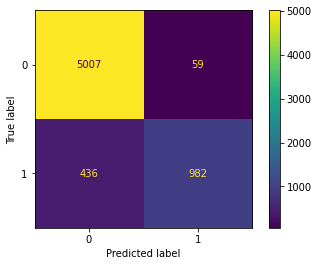

In [45]:
plot_confusion_matrix(be, X_test, y_test)

In [46]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      5066
           1       0.94      0.69      0.80      1418

    accuracy                           0.92      6484
   macro avg       0.93      0.84      0.88      6484
weighted avg       0.93      0.92      0.92      6484



In [47]:
# accuracy

be.score(X_test, y_test)

0.9236582356570019

###### precision recall curve

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


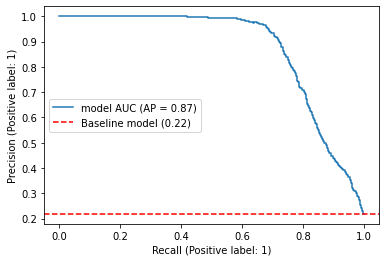

In [48]:
#baseline = avg=sum(test)/tot

plot_precision_recall_curve(estimator=be, X=X_test, y=y_test, name='model AUC')
baseline = y_test.sum() / len(y_test)
plt.axhline(baseline, ls='--', color='r', label=f'Baseline model ({round(baseline,2)})')
plt.legend(loc='best')

###### learning curve

In [49]:
a, b, c = learning_curve(be, X, y, n_jobs=-1, scoring='accuracy')

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


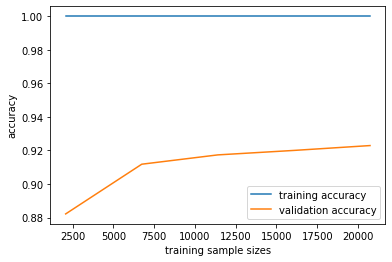

In [50]:
plt.plot(a, b.mean(axis=1), label='training accuracy')
plt.plot(a, c.mean(axis=1),  label='validation accuracy')
plt.xlabel('training sample sizes')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
# above curve = far train + valid =so more tuning

#imp (next)

##### Overfitting:

1. High training accuracy (--- low bias)
2. Low testing/ validation accuracy (--- high variance)
3. Big gap between training and validation curves (--- high variance)
4. Overfitting makes a very complex model and learns even the "noise" in the data, which is undesirable

### Part 2

Remedial measures:

1. Add more training samples, if possible, to allow the model to learn better


2. Working with data at hand:

    Make a simpler model / reduce complexity of model:
- try reducing number of features
- try increasing regularization (lambda)
- try pruning the decision trees

In [50]:
# 1 classifier =
# max depth =tree depth
# split=tree split

In [51]:
grid = {
    
    RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced'):
    {'model__n_estimators':[100,200,300],
     'model__max_depth':[5, 9, 13],
     'model__min_samples_split':[4,6,8],
     'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]},
    
#     LGBMClassifier(class_weight='balanced', random_state=0, n_jobs=-1):
#     {'model__n_estimators':[100,200,300],
#      'model__max_depth':[5, 9, 13],
#      'model__num_leaves': [7,15,31],
#      'model__learning_rate':[0.0001,0.001,0.01,0.1,],
#      'model__boosting_type': ['gbdt', 'goss', 'dart'],
#      'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0),
#                                         KNeighborsRegressor()]} 
}

In [52]:
for clf, param in grid.items():
    print(clf)
    print('-'*50)
    print(param)
    print('\n')

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)
--------------------------------------------------
{'model__n_estimators': [100, 200, 300], 'model__max_depth': [5, 9, 13], 'model__min_samples_split': [4, 6, 8], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}




In [53]:
full_df = pd.DataFrame()
best_algos = {}

for clf, param in grid.items():
    pipe = Pipeline([
    ('coltf', ct),
    ('model', clf)
])

    gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='accuracy',
                            n_jobs=-1, verbose=3, n_iter=4)
    
    gs.fit(X, y)
    
    all_res = pd.DataFrame(gs.cv_results_)

    temp = all_res.loc[:, ['params', 'mean_test_score']]
    algo_name = str(clf).split('(')[0]
    temp['algo'] = algo_name
    
    full_df = pd.concat([full_df, temp])
    best_algos[algo_name] = gs.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [54]:
full_df.sort_values('mean_test_score', ascending=False)

,params,mean_test_score,algo
3,"{'model__n_estimators': 100, 'model__min_sampl...",0.863784,RandomForestClassifier
0,"{'model__n_estimators': 300, 'model__min_sampl...",0.863630,RandomForestClassifier
2,"{'model__n_estimators': 300, 'model__min_sampl...",0.862704,RandomForestClassifier
1,"{'model__n_estimators': 300, 'model__min_sampl...",0.811280,RandomForestClassifier


In [55]:
be = best_algos['RandomForestClassifier']
be

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat_cols',
                                                  OneHotEncoder(

In [56]:
be.fit(X, y)

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat_cols',
                                                  OneHotEncoder(

In [57]:
preds = be.predict(X_test)

In [58]:
confusion_matrix(y_test, preds)

array([[4513,  553],
       [ 306, 1112]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


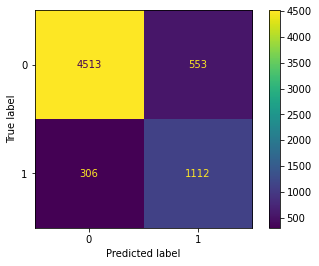

In [59]:
plot_confusion_matrix(be, X_test, y_test)

In [60]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      5066
           1       0.67      0.78      0.72      1418

    accuracy                           0.87      6484
   macro avg       0.80      0.84      0.82      6484
weighted avg       0.88      0.87      0.87      6484



In [61]:
be.score(X_test, y_test)

0.8675200493522517

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


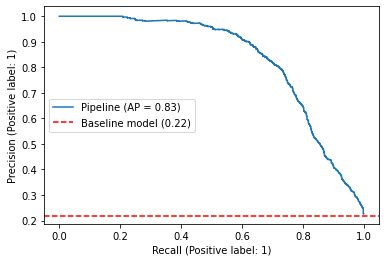

In [62]:
plot_precision_recall_curve(be, X_test, y_test)
baseline = y_test.sum() / len(y_test)
plt.axhline(baseline, ls='--', color='r', label=f'Baseline model ({round(baseline,2)})')
plt.legend(loc='best')

In [63]:
a, b, c = learning_curve(be, X, y, n_jobs=-1, cv=5)

In [64]:
a

array([ 2073,  6739, 11405, 16071, 20737])

In [65]:
b

array([[0.93584178, 0.93101785, 0.93101785, 0.93101785, 0.93101785],
       [0.90859178, 0.91259831, 0.91244992, 0.91244992, 0.91244992],
       [0.8960982 , 0.89864095, 0.90144673, 0.89399386, 0.89399386],
       [0.88706366, 0.88476137, 0.89098376, 0.89297492, 0.88868148],
       [0.87852631, 0.88016589, 0.87920143, 0.88190191, 0.88551864]])

In [66]:
c

array([[0.85689489, 0.87367406, 0.87962963, 0.87326389, 0.87615741],
       [0.86923819, 0.87733848, 0.88657407, 0.87789352, 0.87673611],
       [0.86846673, 0.87020251, 0.88329475, 0.87152778, 0.86902006],
       [0.86692382, 0.86248795, 0.87712191, 0.86940586, 0.86361883],
       [0.85747348, 0.86036644, 0.86979167, 0.86631944, 0.86284722]])

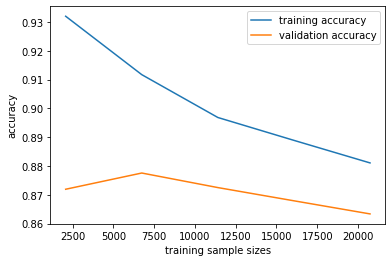

In [67]:
plt.plot(a, b.mean(axis=1), label='training accuracy')
plt.plot(a, c.mean(axis=1),  label='validation accuracy')
plt.xlabel('training sample sizes')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
# see the curves are not far anymore